In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.cross_validation import LabelKFold
from scipy import interp
from sklearn import cross_validation
import pylab as pl

from sklearn import svm
from sklearn.metrics import roc_curve, auc
from os import environ
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline  

C:\Users\tmeshorer\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\tmeshorer\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df_raw = pd.read_csv("../data/raw.csv")
list(df_raw)

['Unnamed: 0',
 'dialog',
 'speaker',
 'tid',
 'id',
 'p_da',
 'da',
 'secs',
 'words',
 'tchange',
 'tstart',
 'tend',
 'start',
 'end',
 'precent_secs_sofar',
 'precent_words_sofar',
 'time_control',
 'words_control']

In [4]:
import math
df_raw = df_raw[['start','dialog','tid','id','p_da','da','secs','words','tchange','tstart','tend','precent_secs_sofar','precent_words_sofar','time_control']]
df_raw = df_raw.dropna()
df_f = df_raw[df_raw.words > 0]


dact_name_map = {
 'SD'  : 'Statement',
 'B'   : 'Backchannel',
 'SV'  : 'Opinion',
 'AA'  : 'Agree',
 '%'   : 'Uninterpretable' ,
 'Q'   : 'Question',
 'A'   : 'Answer',
 'NA'  : 'N/A',
 '+'   : 'Incomplete'   
}

s_with_names = df_f['da']
new_s_with_name = s_with_names.replace(dact_name_map)
df_f['da_name'] = new_s_with_name
df_f['tsec'] = df_f.tend - df_f.tstart
del df_f['tstart']
del df_f['tend']
df_f.head()
df = df_f.copy()
df = df.rename(columns={'words':'Words','secs':'Length','da':'Dialog Act','da_name':'Act','tchange':'Turn Change','precent_secs_sofar':'RTL','time_control':'RTC'})
df = df[['start','dialog','tid','id','Dialog Act','Length','Turn Change','RTL','RTC','Act','Words']]
df


SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


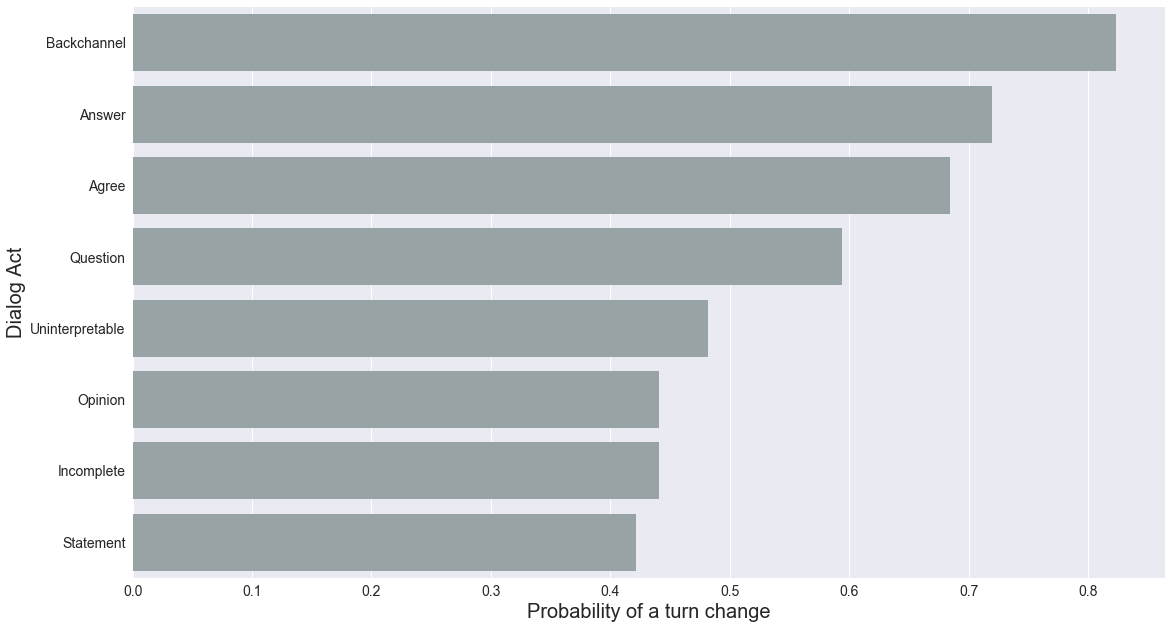

In [26]:
#what precent.
sns.set_palette("husl")
ax = sns.barplot(x="Turn Change", y="Act",data=df,color="#95a5a6",ci=None,order=['Backchannel','Answer','Agree','Question','Uninterpretable','Opinion','Incomplete','Statement']);
ax.set_xlabel("Probability of a turn change")
ax.set_ylabel("Dialog Act")
fig = matplotlib.pyplot.gcf()
matplotlib.rcParams.update({'font.size': 22})
fig.set_size_inches(18.5, 10.5)
plt.savefig('../figures/f2.png')

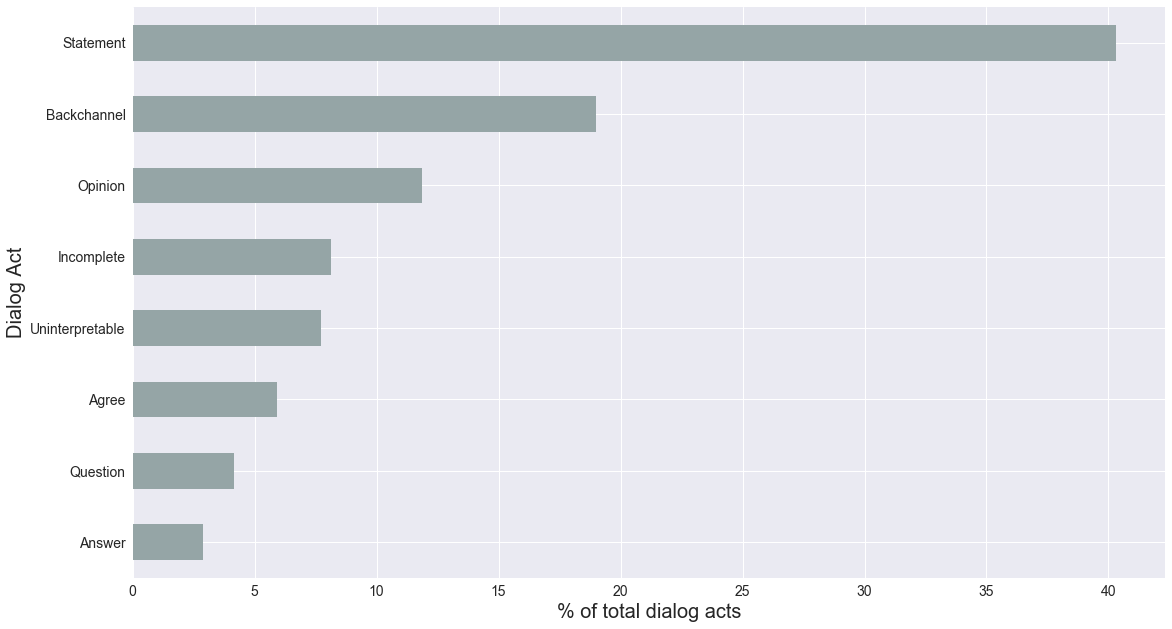

In [27]:
df_precent = df.copy()
gb = df_precent.groupby(["Act"]).count()
gb = gb[['Words']]
total = float(np.sum(gb.Words))

gb['precent'] = gb['Words'] * 100 / total
gb = gb.sort_values(by='precent')
gb_precent = gb[['precent']]
ax = gb_precent.plot(kind="barh",color="#95a5a6",legend=False)
ax.set_xlabel('% of total dialog acts')
ax.set_ylabel('Dialog Act')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig('../figures/f1.png')


In [5]:
df2 = df[df.RTL<600]
list(df2)

['start',
 'dialog',
 'tid',
 'id',
 'Dialog Act',
 'Length',
 'Turn Change',
 'RTL',
 'RTC',
 'Act',
 'Words']

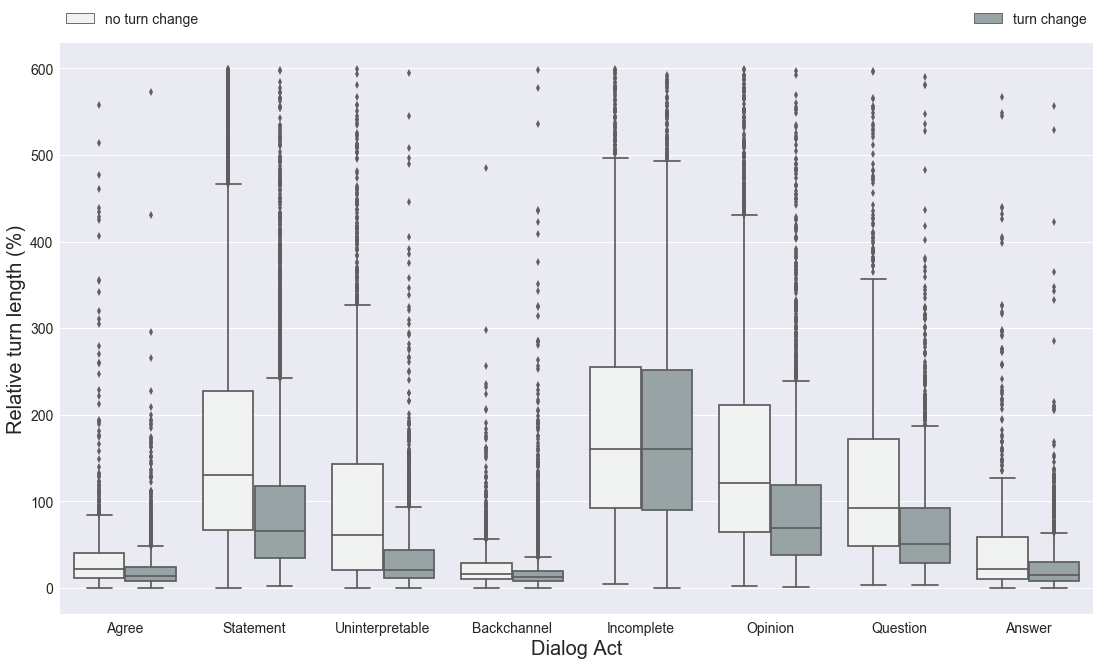

In [30]:
df2 = df[df.RTL<600]
plt.figure(figsize=(5,10)) 
ax = sns.boxplot(y='RTL',x='Act',data=df2,color="#95a5a6",hue="Turn Change")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles,["no turn change","turn change"],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)


ax.set_ylabel('Relative turn length (%)')
ax.set_xlabel('Dialog Act')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig('../figures/f3.png')

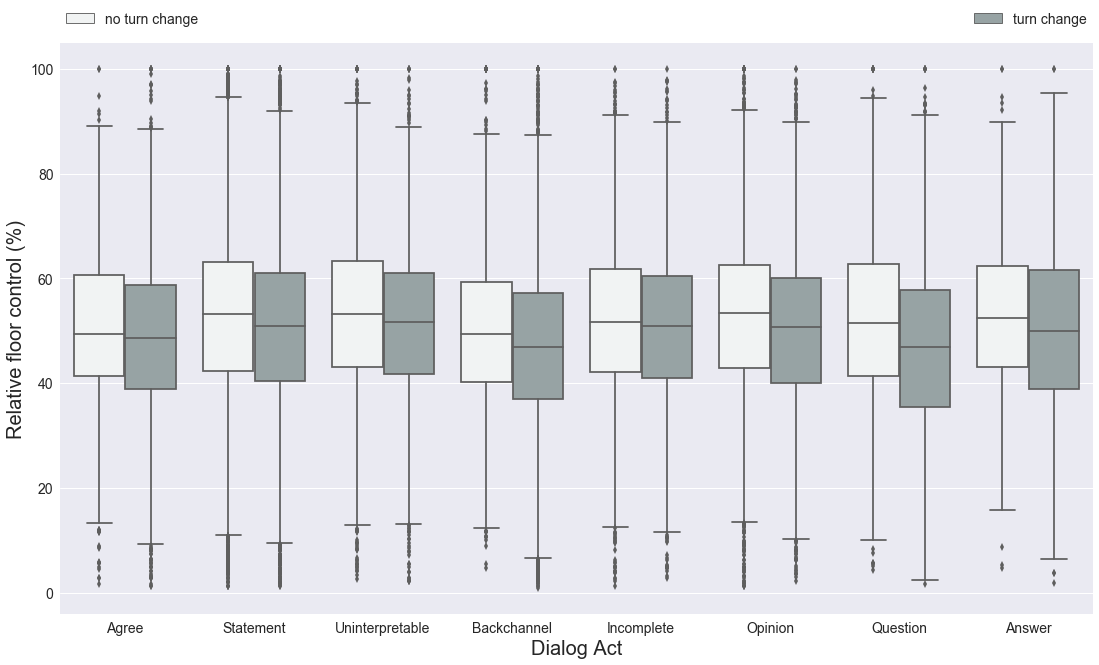

In [31]:
df2 = df[df.RTC<600]
plt.figure(figsize=(5,10)) 
ax = sns.boxplot(y='RTC',x='Act',data=df2,color="#95a5a6",hue="Turn Change")
ax.set_ylabel('Relative floor control (%)')
ax.set_xlabel('Dialog Act')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles,["no turn change","turn change"],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig('../figures/f4.png')

In [8]:
df_desc = df.describe()
#print df_desc.to_latex()

In [105]:
gb = df.groupby(["da_name"])
gb.describe()

precent_secs_sofar  precent_words_sofar        secs  \
da_name                                                                      
Agree           count          166.000000           166.000000  166.000000   
                mean            32.310475            34.144284    0.614128   
                std             68.583298            65.344858    1.259553   
                min              0.000000             1.712329    0.000000   
                25%              8.648636             8.061464    0.262562   
                50%             14.450798            14.417692    0.422063   
                75%             29.355337            29.324205    0.604688   
                max            572.894932           534.360555   14.260250   
Answer          count           69.000000            69.000000   69.000000   
                mean            56.775674            56.358445    0.767161   
                std            112.708952           146.890143    0.926784   
                min              2.585826             3.762663    0.115125   
                25%              8.904025             7.467532    0.342250   
                50%             15.381979            18.394161    0.466125   
                75%             42.922962            33.268482    0.760625   
                max            637.831595          1089.676425    5.548250   
Backchannel     count          407.000000           407.000000  407.000000   
                mean            16.547963            15.621613    0.403063   
                std             31.267402            21.627814    0.216175   
                min              0.000000             1.799100    0.000000   
                25%              6.851741             6.466789    0.296187   
                50%             10.995262             9.790210    0.373250   
                75%             16.876189            17.073453    0.462750   
                max            435.752634           289.256198    2.823375   
Incomplete      count          145.000000           145.000000  145.000000   
                mean           223.804288           239.712782    2.016620   
                std            233.291358           318.807668    1.744315   
                min             12.656378            24.000000    0.242625   
                25%             95.604321           100.653595    0.950000   
                50%            160.843967           176.635514    1.538125   
...                                   ...                  ...         ...   
Opinion         std            144.023300           129.626267    3.165661   
                min              4.827645             9.938971    0.122875   
                25%             44.168340            62.011923    1.232531   
                50%             88.904747           103.057984    2.075750   
                75%            172.723560           170.825797    3.736187   
                max            856.856264           933.738602   29.177625   
Question        count           70.000000            70.000000   70.000000   
                mean            80.286479            86.558640    1.961589   
                std             67.076145            62.319742    1.751761   
                min              3.442752             4.761905    0.335625   
                25%             33.503103            44.344721    0.945750   
                50%             63.346412            69.518875    1.485688   
                75%            105.357679           107.832526    2.311875   
                max            277.947246           286.761711   12.393000   
Statement       count          723.000000           723.000000  723.000000   
                mean           163.940404           177.399894    2.568646   
                std            182.705722           203.052001    2.022314   
                min              3.232208             5.291005    0.000000   
                25%             52.790269    